In [1]:
from src.models.unet import Unet

In [2]:
from typing import Union, Dict

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import dask
from scipy import io
import xarray as xr
from torch.utils.data import DataLoader

from src.datamodules.imerg_precipitation import IMERGPrecipitationDataModule
import torch

from src.utilities.utils import (
    rename_state_dict_keys_and_save,
)

In [3]:
# BaseDataModule **kwargs
kwargs = {
    "batch_size": 4,
    "eval_batch_size": 4,
    "num_workers": 4,
    "pin_memory": True,
    "drop_last": False,
    "verbose": True,
}

boxes = ["0,0", "1,0", "2,0", "2,1"]
# boxes = "all"

datamodule = IMERGPrecipitationDataModule(
    # data_dir="/Volumes/external_disk_seal/data/imerg_datasets",
    data_dir="/Users/ds423/git_uni/dyffusion/data/imerg-precipitation",
    boxes=boxes,
    box_size=128,
    window=1,
    horizon=4,
    sequence_dt=2,
    prediction_horizon=None,
    multi_horizon=False,
    pixelwise_normalization=True,
    save_and_load_as_numpy=False,
    **kwargs,
)

In [4]:
# run setup to get datamodule._data_train and datamodule._data_val
# the _data_train and _data_val will be normalised.
datamodule.setup("fit")

In [5]:
datamodule.setup("test")

In [20]:
train_dataloader = DataLoader(datamodule._data_train,
                              batch_size=datamodule.hparams["batch_size"])

val_dataloader = DataLoader(datamodule._data_val,
                            batch_size=datamodule.hparams["batch_size"])

test_dataloader = DataLoader(datamodule._data_test,
                             batch_size=datamodule.hparams["batch_size"])

In [9]:

kwargs = {
    "num_input_channels": 2,
    "num_output_channels": 1,
    "loss_function": 'mse',
    "num_conditional_channels": 0
}

model = Unet(
        dim=64,
        dim_mults=[1, 2, 4],
        num_conditions=0,
        resnet_block_groups=8,
        with_time_emb=True,
        block_dropout=0.0,  # for second block in resnet block
        block_dropout1=0.0,  # for first block in resnet block
        attn_dropout= 0.0,
        input_dropout= 0.0,
        double_conv_layer=True,
        learned_variance=False,
        learned_sinusoidal_cond=False,
        learned_sinusoidal_dim=16,
        outer_sample_mode=None,  # bilinear or nearest
        upsample_dims=None,  # (256, 256) or (128, 128)
        keep_spatial_dims=False,
        init_kernel_size=7,
        init_padding=3,
        init_stride=1,
        verbose=True,
        **kwargs
)

In [10]:
# Get the model's parameter names
parameter_names = [name for name, _ in model.named_parameters()]

# Print the parameter names
for name in parameter_names:
    print(name)

init_conv.weight
init_conv.bias
time_emb_mlp.1.weight
time_emb_mlp.1.bias
time_emb_mlp.3.weight
time_emb_mlp.3.bias
downs.0.0.mlp.1.weight
downs.0.0.mlp.1.bias
downs.0.0.block1.proj.weight
downs.0.0.block1.proj.bias
downs.0.0.block1.norm.weight
downs.0.0.block1.norm.bias
downs.0.0.block2.proj.weight
downs.0.0.block2.proj.bias
downs.0.0.block2.norm.weight
downs.0.0.block2.norm.bias
downs.0.1.mlp.1.weight
downs.0.1.mlp.1.bias
downs.0.1.block1.proj.weight
downs.0.1.block1.proj.bias
downs.0.1.block1.norm.weight
downs.0.1.block1.norm.bias
downs.0.1.block2.proj.weight
downs.0.1.block2.proj.bias
downs.0.1.block2.norm.weight
downs.0.1.block2.norm.bias
downs.0.2.fn.fn.to_qkv.1.weight
downs.0.2.fn.fn.to_out.weight
downs.0.2.fn.fn.to_out.bias
downs.0.2.fn.norm.g
downs.0.3.weight
downs.0.3.bias
downs.1.0.mlp.1.weight
downs.1.0.mlp.1.bias
downs.1.0.block1.proj.weight
downs.1.0.block1.proj.bias
downs.1.0.block1.norm.weight
downs.1.0.block1.norm.bias
downs.1.0.block2.proj.weight
downs.1.0.block2.proj

In [16]:
ckpt_id = "ilda99in" 
# ckpt_id = "deglr0nd"

model_path = f"/Users/ds423/git_uni/dyffusion/results/checkpoints/{ckpt_id}/ImergPrecipitation-Interpolation4h_None_epoch005_seed8.ckpt"
# model_path = f"/Users/ds423/git_uni/dyffusion/results/checkpoints/xoj31u6n/ImergPrecipitation-Interpolation4h_None_epoch006_seed8.ckpt"
# model_path = f"/Users/ds423/git_uni/dyffusion/results/checkpoints/{ckpt_id}/ImergPrecipitation-Interpolation4h_None_epoch036_seed8.ckpt"
# model_path = f"/Users/ds423/git_uni/dyffusion/results/checkpoints/{ckpt_id}/last.ckpt"

In [17]:
device = 'cpu' or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_state = torch.load(model_path, map_location=device)

# rename weights (sometimes needed for backwards compatibility)
state_dict = rename_state_dict_keys_and_save(model_state, model_path)

# Reload weights
# remove all keys with model.interpolator prefix
state_dict = {k: v for k, v in state_dict.items() if not k.startswith("model.interpolator")}

# strip the 'model.' prefix from the keys in the state dictionary
stripped_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace('model.', '')
    stripped_state_dict[new_key] = value

In [18]:
# load in a model and put it in eval mode.
model.load_state_dict(stripped_state_dict, strict=False)
model.eval()

Unet(
  (criterion): MSELoss()
  (init_conv): Conv2d(2, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (dropout_input): Dropout(p=0.0, inplace=False)
  (dropout_input_for_residual): Dropout(p=0.0, inplace=False)
  (time_emb_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size

In [21]:
# make an iterable out of it. 
iter_train_loader = iter(train_dataloader)
iter_val_loader = iter(val_dataloader)
iter_test_loader = iter(test_dataloader)

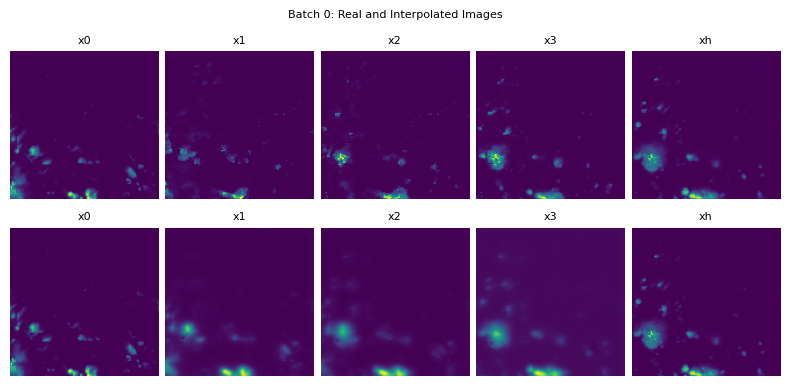

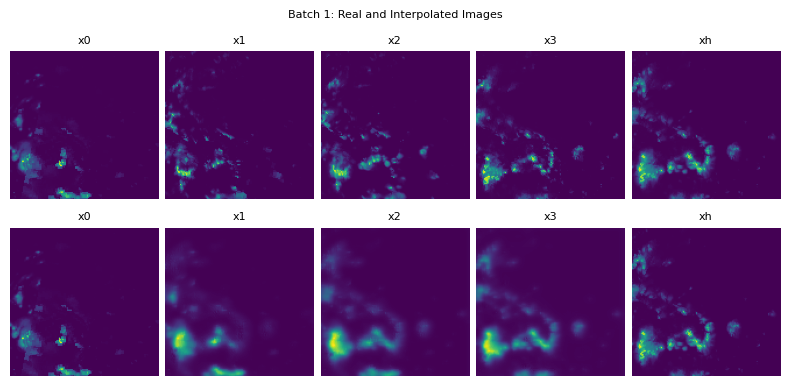

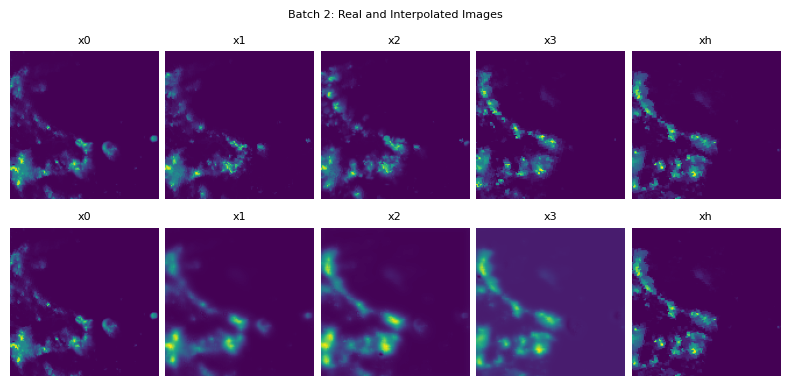

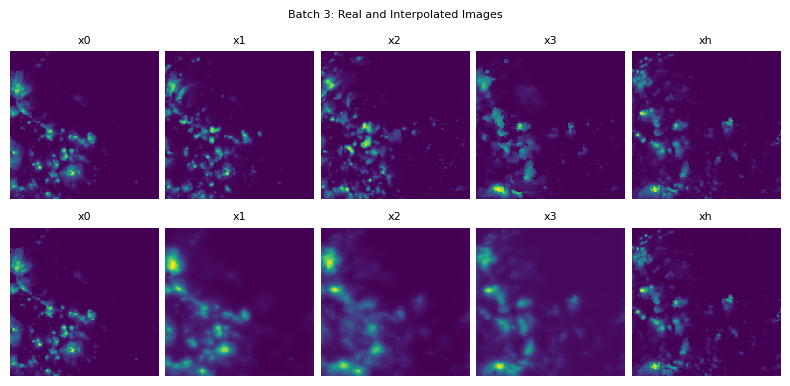

In [22]:
# X = next(iter_train_loader)
# X = next(iter_val_loader)
X = next(iter_test_loader)

batch = 0
c = 0

# get x0 and xh.
x0 = X["dynamics"][batch, 0, :, :, :]
xh = X["dynamics"][batch, -1, :, :, :]
# get interpolated values. 
x_interp = X["dynamics"][batch, 1:-1, :, :, :]

pred_t1 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([1], dtype=torch.long))
pred_t2 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([2], dtype=torch.long))
pred_t3 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([3], dtype=torch.long))

fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle(f'Batch {batch}: Real and Interpolated Images', fontsize=8)
for i in range(5):
    # real images.
    axs[0, i].imshow(X["dynamics"][batch, i, 0, :, :])
    axs[0, i].axis("off")
    axs[0, i].set_title(f"x{i}" if i != 4 else "xh", fontsize=8)

for e, img in enumerate([x0, pred_t1.squeeze(0).detach().cpu(), pred_t2.squeeze(0).detach().cpu(), pred_t3.squeeze(0).detach().cpu(), xh]):
    # real + interp
    axs[1, e].imshow(img[0, :, :])
    axs[1, e].axis("off")
    axs[1, e].set_title(f"x{e}" if e != 4 else "xh", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)


batch = 1
# get x0 and xh.
x0 = X["dynamics"][batch, 0, :, :, :]
xh = X["dynamics"][batch, -1, :, :, :]
# get interpolated values. 
x_interp = X["dynamics"][batch, 1:-1, :, :, :]

pred_t1 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([1], dtype=torch.long))
pred_t2 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([2], dtype=torch.long))
pred_t3 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([3], dtype=torch.long))

fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle(f'Batch {batch}: Real and Interpolated Images', fontsize=8)
for i in range(5):
    # real images.
    axs[0, i].imshow(X["dynamics"][batch, i, 0, :, :])
    axs[0, i].axis("off")
    axs[0, i].set_title(f"x{i}" if i != 4 else "xh", fontsize=8)

for e, img in enumerate([x0, pred_t1.squeeze(0).detach().cpu(), pred_t2.squeeze(0).detach().cpu(), pred_t3.squeeze(0).detach().cpu(), xh]):
    # real + interp
    axs[1, e].imshow(img[0, :, :])
    axs[1, e].axis("off")
    axs[1, e].set_title(f"x{e}" if e != 4 else "xh", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)


batch = 2
# get x0 and xh.
x0 = X["dynamics"][batch, 0, :, :, :]
xh = X["dynamics"][batch, -1, :, :, :]
# get interpolated values. 
x_interp = X["dynamics"][batch, 1:-1, :, :, :]

pred_t1 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([1], dtype=torch.long))
pred_t2 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([2], dtype=torch.long))
pred_t3 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([3], dtype=torch.long))

fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle(f'Batch {batch}: Real and Interpolated Images', fontsize=8)
for i in range(5):
    # real images.
    axs[0, i].imshow(X["dynamics"][batch, i, 0, :, :])
    axs[0, i].axis("off")
    axs[0, i].set_title(f"x{i}" if i != 4 else "xh", fontsize=8)

for e, img in enumerate([x0, pred_t1.squeeze(0).detach().cpu(), pred_t2.squeeze(0).detach().cpu(), pred_t3.squeeze(0).detach().cpu(), xh]):
    # real + interp
    axs[1, e].imshow(img[0, :, :])
    axs[1, e].axis("off")
    axs[1, e].set_title(f"x{e}" if e != 4 else "xh", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)


batch = 3
# get x0 and xh.
x0 = X["dynamics"][batch, 0, :, :, :]
xh = X["dynamics"][batch, -1, :, :, :]
# get interpolated values. 
x_interp = X["dynamics"][batch, 1:-1, :, :, :]

pred_t1 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([1], dtype=torch.long))
pred_t2 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([2], dtype=torch.long))
pred_t3 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([3], dtype=torch.long))

fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle(f'Batch {batch}: Real and Interpolated Images', fontsize=8)
for i in range(5):
    # real images.
    axs[0, i].imshow(X["dynamics"][batch, i, 0, :, :])
    axs[0, i].axis("off")
    axs[0, i].set_title(f"x{i}" if i != 4 else "xh", fontsize=8)

for e, img in enumerate([x0, pred_t1.squeeze(0).detach().cpu(), pred_t2.squeeze(0).detach().cpu(), pred_t3.squeeze(0).detach().cpu(), xh]):
    # real + interp
    axs[1, e].imshow(img[0, :, :])
    axs[1, e].axis("off")
    axs[1, e].set_title(f"x{e}" if e != 4 else "xh", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

* might need to add in the entire temporal sequence due to 30 minutes already being quite long in terms of precipitation. 
* might need to add in some similarity metric to improve the sharpness of the interpolated images. 


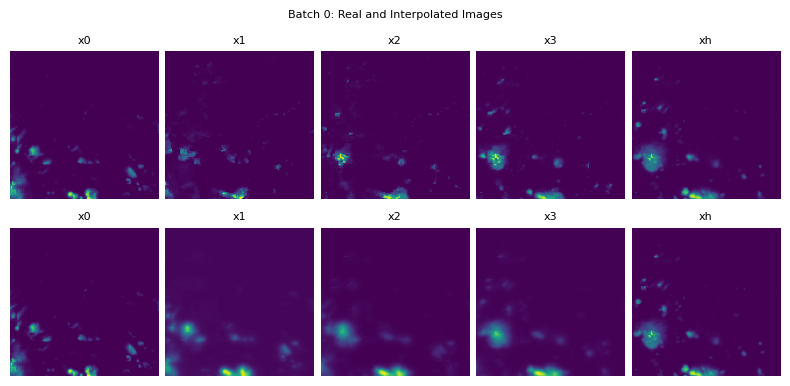

In [93]:
# need to test out similarity score. 
# get x0 and xh.
batch = 0
x0 = X["dynamics"][batch, 0, :, :, :]
xh = X["dynamics"][batch, -1, :, :, :]
# get interpolated values. 
x_interp = X["dynamics"][batch, 1:-1, :, :, :]

pred_t1 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([1], dtype=torch.long))
pred_t2 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([2], dtype=torch.long))
pred_t3 = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([3], dtype=torch.long))

fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle(f'Batch {batch}: Real and Interpolated Images', fontsize=8)
for i in range(5):
    # real images.
    axs[0, i].imshow(X["dynamics"][batch, i, 0, :, :])
    axs[0, i].axis("off")
    axs[0, i].set_title(f"x{i}" if i != 4 else "xh", fontsize=8)

for e, img in enumerate([x0, pred_t1.squeeze(0).detach().cpu(), pred_t2.squeeze(0).detach().cpu(), pred_t3.squeeze(0).detach().cpu(), xh]):
    # real + interp
    axs[1, e].imshow(img[0, :, :])
    axs[1, e].axis("off")
    axs[1, e].set_title(f"x{e}" if e != 4 else "xh", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)



ssim between image and itself = 1.0
ssim between image and prediction (interpolation) = 0.9995821118354797
mse loss between image and pred = 0.006713166367262602


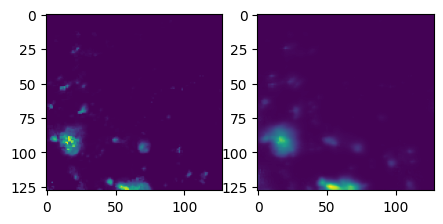

In [94]:
# !pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import torch.nn as nn

t = 3
image = x_interp.unsqueeze(0)[:, t-1, :, :, :]
pred = model(torch.concat([x0, xh]).unsqueeze(0), time=torch.tensor([t], dtype=torch.long)).detach().cpu()
ssim_exact = ssim(image, image)
ssim_pred_target = ssim(image, pred)
mse = nn.MSELoss()(image, pred)

print(f"ssim between image and itself = {ssim_exact}")
print(f"ssim between image and prediction (interpolation) = {ssim_pred_target}")
print(f"mse loss between image and pred = {mse}")

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[0].imshow(image[0, 0, :, :])
axs[1].imshow(pred[0, 0, :, :])